# Introduction

This exercise addresses how to deal with data variables for MODFLOW 6 objects in FloPy. 
FloPy handles MODFLOW 6 model data in a diffferent manner from other MODFLOW model variants. 

FloPy stores MODFLOW 6 model data in data objects. These data objects are accesible via simulation or model packages. 
Data can be added to a package during construction or at a later stage through package attributes.

There are three (at the time of writting) types of model data objects:
 - MFDataScalar
 - MFDataArray
 - MFDataList

The current exercise will focus on List Data (MFDataList objects).

## List Data

Some MODFLOW 6 data can conveniently be stored in tabular format, such as in a numpy recarray or pandas dataframe. These data are stored by FloPy in MFList or MFTransientList objects. 

MFList data can contain a single or multiple rows. Each column of the list contains the same data type. Single row MFLists usualy pertain to pacakge options (such as the BUY pacakge's pacakgedata). Multiple row MFLists are used for things like the 'conectiondata' for the MAW or Lake packages.

Perhaps most used are MFTransientList data, in which FloPy stores lists of stress period data. These are often used to assign stress package values at specifc cells and stress periods (i.e. pumping rates in the WEL package). 

In the following exercise we will adapt the model from excerise 01 by adding two new stress periods. We will then place a well in the lower aquifer using the WEL package. Diferent pumping rates will be assigned to each stress period to demosntrate the use of MFTranslientList data.

In [1]:
# Import necessary libraries
# for the purposes of this course we are using frozen versions of flopy to avoid depenecy failures.  
import os 
import sys
sys.path.append('../dependencies/')
import flopy
import numpy as np
import matplotlib.pyplot as plt

# Build a Model
The following cell constructs the same model developed in exercise 1 with some modification. Two additional stress period are added to the TDIS package so that MFTransientList's can be demonstrated.

In [2]:
# simulation
sim_name = 'symple_ex05'
exe_name = os.path.join('..','bin', 'mf6.exe')
workspace = os.path.join('..','models','symple_ex05')

sim = flopy.mf6.MFSimulation(sim_name=sim_name,
                            exe_name=exe_name,
                            version="mf6", 
                            sim_ws=workspace)
# tdis
time_units = 'days'
perioddata = [(1.0, 1, 1.0), 
                (1.0, 1, 1.0), # an additional stress period has been added
                (1.0, 1, 1.0)] # an additional stress period has been added
nper = len(perioddata)
tdis = flopy.mf6.ModflowTdis(sim, pname="tdis",
                                  nper=nper, 
                                  perioddata=perioddata, 
                                  time_units=time_units)
# model
model_name = 'symp03'
gwf = flopy.mf6.ModflowGwf(sim,
                            modelname=model_name,
                            save_flows=True, print_flows=True)
# ims pacakge
ims = flopy.mf6.ModflowIms(sim,
                            pname="ims",
                            complexity="SIMPLE",
                            linear_acceleration="BICGSTAB",)
sim.register_ims_package(ims, [gwf.name])

# dis package
length_units = "METERS"
nlay = 3
Lx = 1000
Ly = 1500
delr = 100 #row length
delc = 100 #column length
ncol = int(Lx/delc)
nrow = int(Ly/delr)
top = 50
botm = [40, 35, 0]

dis = flopy.mf6.ModflowGwfdis(
                            gwf,
                            nlay=nlay,
                            nrow=nrow,
                            ncol=ncol,
                            delr=delr,
                            delc=delc,
                            top=top,
                            botm=botm)

# IC package
strt = np.full((nlay, nrow, ncol), top)
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=strt)

# NPF package
k = [5, 0.1, 10]
icelltype = [1, 0, 0]

npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, k=k,
                              save_flows=True, 
                              save_specific_discharge=True)

# RCH package
recharge = 50/1000/365
rcha = flopy.mf6.ModflowGwfrcha(gwf, pname='rch', recharge=recharge)

# RIV package
riv_row = 7
stage = top - 5
rbot = botm[0]
cond = 0.1 * delr*delc/1

riv_spd = []
for col in range(ncol):
    riv_spd.append(((0, riv_row, col), stage, cond, rbot))

riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd, boundnames=True)

# OC package
# the name of the binary head file
headfile = f"{gwf.name}.hds"
head_filerecord = [headfile]
# the name of the binary budget file
budgetfile = f"{gwf.name}.cbb"
budget_filerecord = [budgetfile]

# which outputs are crecored to the binary files
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
# which outputs are printed in the list file
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(gwf,
                            saverecord=saverecord,
                            head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord,
                            printrecord=printrecord)

## **Specifying List Data**

For the purposes of this exercise we will only demonstrate the use of multirow list data to assign stress perdod data. Ths is the most commmon use case for list data. Single row cases tend to be package specific. These will be highlighted throught the course when they come up.

### **Time-varying boundary conditions**
When building stress packages (i.e. WEL, CHD, GHB, etc.), FloPy accepts stress period data as a dictionary of numpy recarrays, or a dictionary of lists of tuples, in which the ditionary key is the zero-based stress period. A dictionary of lists of tuples tends to be easier to generate. Internaly, FloPy stores the stress period data as a dictionary of numpy recarrays.

A recarray (or list of tuples) will have a specific structure depending on the package it is assigned to. The structure usualy relates to the structure of stress period data in the respective MODFLOW 6 package input file (see the MODFLOW6 manual for details). For example, for the WEL package default structure for each row (or tuple in the list) pertaining to a single stress period would be:

    (cellid, pumping_rate)

In which 'cellid' is a tuple contaning the cell identifier. In the case of a structured DIS grid:
    
    ((layer, row, col), pumping_rate)

Fortunately, FloPy has a built-in method to generate an empty recarray with the necessary structure for any pacakge, as is shown below:


In [3]:
# generate empty dictionary of recarays for the WEL pacakge
wel_spd = flopy.mf6.ModflowGwfwel.stress_period_data.empty(gwf)

# you can inspect the recarray dtypes. This is the format the recarray or list of tuples must have.
wel_spd[0].dtype

dtype((numpy.record, [('cellid', 'O'), ('q', '<f8')]))

In [4]:
# construct a dctionary of stress period data
# we will place a well in the lower layer (layer 2), at row 5 and column 3. 
# It will have pumping rate of -100 m3/d (negative is out).
# The well will pump during the first and last stress period, and be inactie during the second.
# In the last stress period, we will place a second well in the lower layer (layer 2), at row 10 and column 6 with -50 m3/d. 

# create an empty dictionary.
wel_spd = {}

# create the list of tuples for the first stress period
spd1 = [((2, 5, 3), -100)]

# adding an empty list deactivates pumping in the second stress period.
# If nothing were assinged, pumping would continue as per the previous stress period.
spd2= []

# add a second entry (tuple) to the list to add an additional well
spd3 = [((2, 5, 3), -100), # the first well
        ((2, 10, 6), -50)]  # the second well

# Assign easch list to the relevant key in the dictionary. 
# This could have been done directly, but in this way eah step is shown explicitly.
wel_spd[0] = spd1
wel_spd[1] = spd2
wel_spd[2] = spd3

# inspect the stress period data dictionary
wel_spd

{0: [((2, 5, 3), -100)], 1: [], 2: [((2, 5, 3), -100), ((2, 10, 6), -50)]}

In [5]:
# construct the WEL package
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd,
                                    print_input=True, 
                                    print_flows=True,
                                    save_flows=True)

## **Write the model files**
Write the model files. You can compare them to those in the exercise 01 folder to see how they have changed.

In [6]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model symp03...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rch...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 10 based on size of stress_period_data
    writing package oc...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
FloPy is using the following  executable to run the model: ..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software 

(True, [])

# Plot the results at the end of each stress period

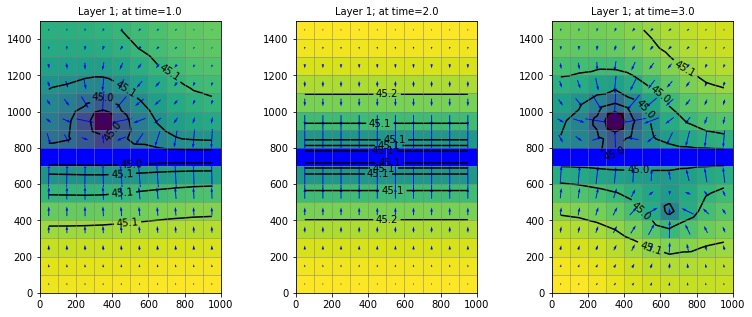

In [8]:
# plot outputs from the upper layer. The code below is the same as used in Exercise 01.
# load outputs
# the head file output can be loaded from the model object:
hds = gwf.output.head()
# get the specific discharge from the cell budget file
cbb = gwf.output.budget()


# plot
fig = plt.figure(figsize=(13, 5))
x = 1
for totim in hds.get_times():
    ax = fig.add_subplot(1, 3, x, aspect='equal')
    ax.set_title(f'Layer 1; at time={totim}', fontsize=10)
    x += 1

    heads = hds.get_data(totim=totim)
    spdis = cbb.get_data(text="SPDIS",totim=totim)[-1]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

    # first instantiate a PlotMapView
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)

    # Plot heads
    # plot the array of heads 
    head_array = mm.plot_array(heads)
    # add contour lines with contour_array()
    contours = mm.contour_array(heads, colors='black')
    # add labels to contour lines
    plt.clabel(contours, fmt="%2.1f")

    # Plot grid 
    # you can plot BC cells using the plot_bc() 
    mm.plot_bc('RIV', color='blue')
    # and plot the model grid if desired
    mm.plot_grid(lw=0.5)

    # add specific discharge vectors using plot_vector()
    quiver = mm.plot_vector(qx, qy, normalize=False, color='blue')